# 📊 Retail Sales ML Pipeline

This notebook builds two regression models to predict `Total Amount` from retail transaction data using Decision Tree and Random Forest.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Load dataset
# Get Raw GitHub URL

DATA_URL = "https://raw.githubusercontent.com/msselizabeth/smart-ml-retail-model/main/data/raw/retail_sales_dataset.csv"

df = pd.read_csv(DATA_URL)
df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [2]:
#  Data Cleaning

# 1. Strip whitespace from column names and string values
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 2. Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 3. Keep only 2023 transactions
df = df[df['Date'].dt.year == 2023]

# 4. Drop duplicate rows (if any)
df = df.drop_duplicates()

# 5. Remove rows with missing values
df = df.dropna()

# 6. Filter out invalid or suspicious numeric values
df = df[df['Age'] > 0]
df = df[df['Price per Unit'] > 0]
df = df[df['Total Amount'] > 0]

# Optional: Reset index after cleaning
df = df.reset_index(drop=True)

# Preview cleaned data
df.head()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_77400/57625090.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    998 non-null    int64         
 1   Date              998 non-null    datetime64[ns]
 2   Customer ID       998 non-null    object        
 3   Gender            998 non-null    object        
 4   Age               998 non-null    int64         
 5   Product Category  998 non-null    object        
 6   Quantity          998 non-null    int64         
 7   Price per Unit    998 non-null    int64         
 8   Total Amount      998 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 70.3+ KB


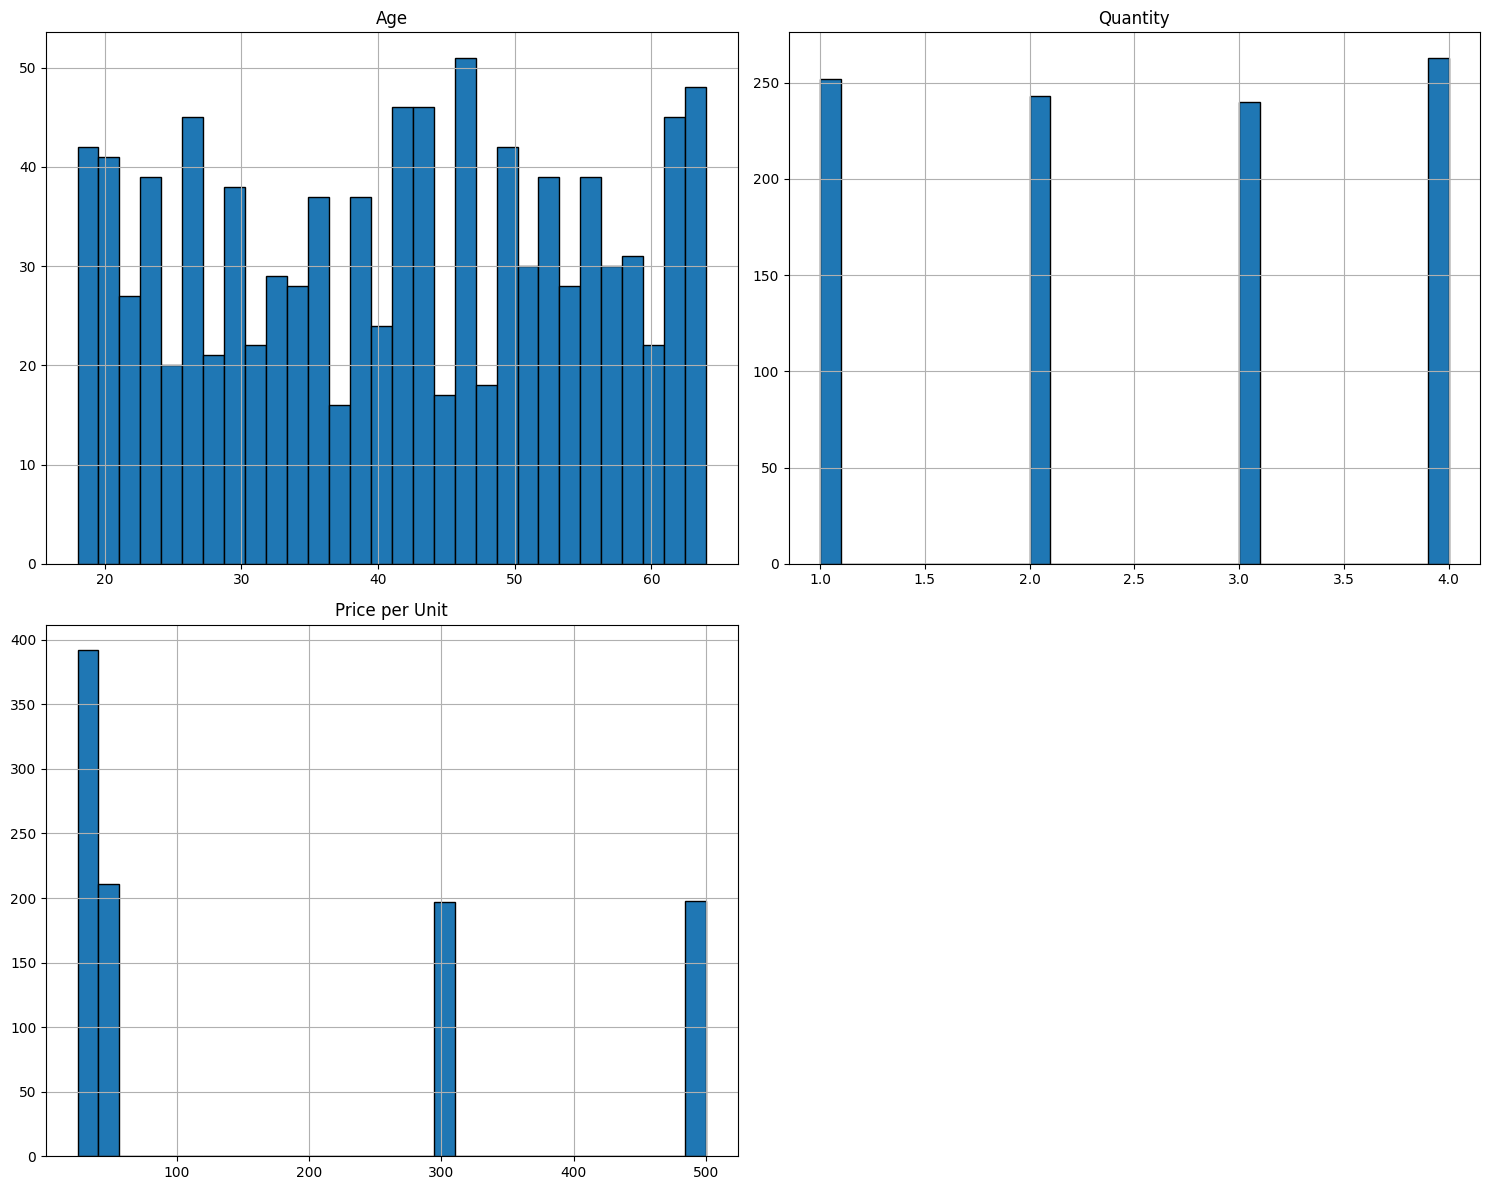

In [4]:
# Visualize the distribution of numeric features
numeric_cols = ['Age', 'Quantity', 'Price per Unit']

# Set up subplots
df[numeric_cols].hist(bins=30, figsize=(15, 12), layout=(2, 2),edgecolor='k')
plt.tight_layout()
plt.show()

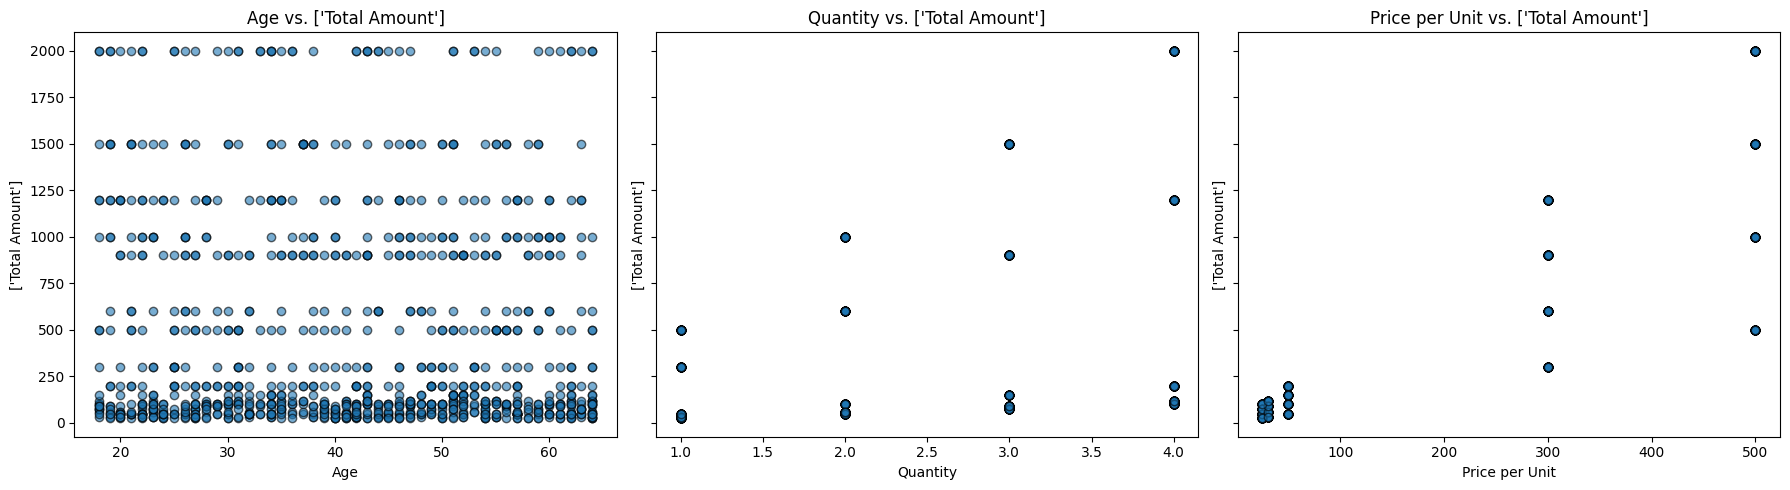

In [5]:
# Scatterplots
y_col=['Total Amount']

# Create one row of scatter plots, one per numeric feature
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(6 * len(numeric_cols), 5), sharey=True)

# Handle case when there's only one axis
if len(numeric_cols) == 1:
    axes = [axes]

# Loop through numeric columns
for ax, col in zip(axes, numeric_cols):
    ax.scatter(df[col], df[y_col], alpha=0.6, edgecolor='k')
    ax.set_xlabel(col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{col} vs. {y_col}')

plt.tight_layout()
plt.show()

In [6]:
#Quick checks        
print(df.describe())   
print(df['Product Category'].value_counts())  
print(df.groupby('Product Category')['Total Amount'].sum())

       Transaction ID                           Date         Age    Quantity  \
count      998.000000                            998  998.000000  998.000000   
mean       500.640281  2023-07-02 15:40:45.691382784   41.377756    2.515030   
min          1.000000            2023-01-01 00:00:00   18.000000    1.000000   
25%        251.250000            2023-04-08 00:00:00   29.000000    1.000000   
50%        500.500000            2023-06-29 00:00:00   42.000000    3.000000   
75%        750.750000            2023-10-04 00:00:00   53.000000    4.000000   
max       1000.000000            2023-12-31 00:00:00   64.000000    4.000000   
std        288.924735                            NaN   13.688342    1.132751   

       Price per Unit  Total Amount  
count      998.000000    998.000000  
mean       179.719439    455.380762  
min         25.000000     25.000000  
25%         30.000000     60.000000  
50%         50.000000    135.000000  
75%        300.000000    900.000000  
max        50

In [7]:
# Check for outliers in 'Total Amount'
# Compute Q1, Q3, and IQR for Total Amount
Q1 = df['Total Amount'].quantile(0.25)
Q3 = df['Total Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
lo_outliers = df[df['Total Amount'] < lower_bound].shape[0]
hi_outliers = df[df['Total Amount'] > upper_bound].shape[0]

print(f"IQR method → lower bound: {lower_bound}, upper bound: {upper_bound}")
print(f"Number of lower outliers: {lo_outliers}")
print(f"Number of upper outliers: {hi_outliers}")

IQR method → lower bound: -1200.0, upper bound: 2160.0
Number of lower outliers: 0
Number of upper outliers: 0


In [8]:
# Check outliers in Price per Unit
summary = []
for category, grp in df.groupby('Product Category'):
    Q1 = grp['Price per Unit'].quantile(0.25)
    Q3 = grp['Price per Unit'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_low = (grp['Price per Unit'] < lower).sum()
    n_high = (grp['Price per Unit'] > upper).sum()
    summary.append({
        'Category':       category,
        'Q1':             Q1,
        'Q3':             Q3,
        'IQR':            IQR,
        'Lower Bound':    lower,
        'Upper Bound':    upper,
        'Lower Outliers': n_low,
        'Upper Outliers': n_high
    })

outlier_price= pd.DataFrame(summary).set_index('Category')
print(outlier_price)

               Q1     Q3    IQR  Lower Bound  Upper Bound  Lower Outliers  \
Category                                                                    
Beauty       30.0  300.0  270.0       -375.0        705.0               0   
Clothing     30.0  300.0  270.0       -375.0        705.0               0   
Electronics  30.0  300.0  270.0       -375.0        705.0               0   

             Upper Outliers  
Category                     
Beauty                    0  
Clothing                  0  
Electronics               0  


In [9]:
# Pricing trends
# Pivot: rows are product_category, columns are price_per_unit, values are transaction counts
price_counts_pivot = (df
    .groupby(['Product Category', 'Price per Unit'])
    .size()
    .unstack(fill_value=0)
)

# Display or inspect
print(price_counts_pivot)

Price per Unit    25   30   50   300  500
Product Category                         
Beauty             63   56   67   53   67
Clothing           75   65   75   72   64
Electronics        72   61   69   72   67


In [10]:
# Split price points per gender
# 1) Pivot for Male transactions
male_pivot = (
    df[df['Gender'] == 'Male']
      .groupby(['Product Category', 'Price per Unit'])
      .size()
      .unstack(fill_value=0)
)

# 2) Pivot for Female transactions
female_pivot = (
    df[df['Gender'] == 'Female']
      .groupby(['Product Category', 'Price per Unit'])
      .size()
      .unstack(fill_value=0)
)

# 3) Display table
from IPython.display import display

print("=== Male: Transaction Counts by Category & Price ===")
display(male_pivot)

print("\n=== Female: Transaction Counts by Category & Price ===")
display(female_pivot)

=== Male: Transaction Counts by Category & Price ===


Price per Unit,25,30,50,300,500
Product Category,,,,,
Beauty,23,32,30,24,31
Clothing,38,28,46,33,32
Electronics,34,30,37,34,36



=== Female: Transaction Counts by Category & Price ===


Price per Unit,25,30,50,300,500
Product Category,,,,,
Beauty,40,24,37,29,36
Clothing,37,37,29,39,32
Electronics,38,31,32,38,31


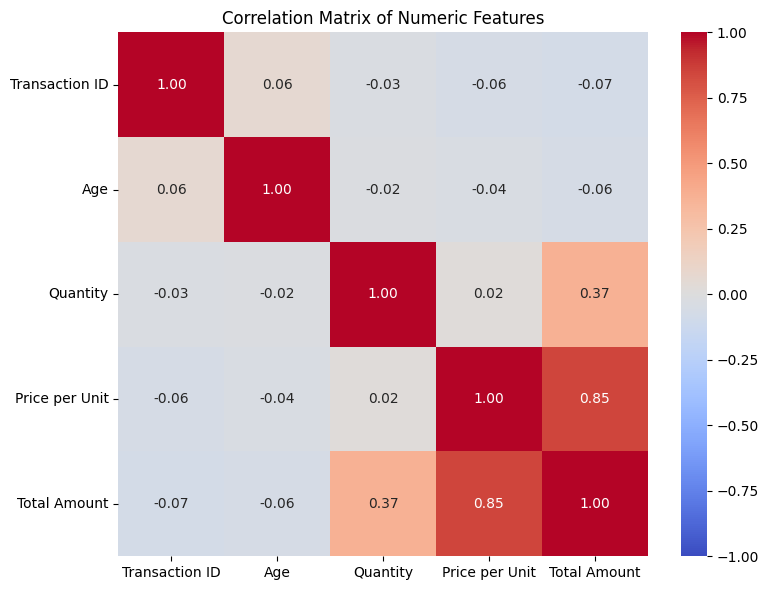

In [11]:
# Correlation matrix (only numeric columns)
numeric_cols = df.select_dtypes(include='number')

# Compute correlation
corr_matrix = numeric_cols.corr()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

In [12]:

# Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Holiday'] = df['Date'].dt.weekday >= 5

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Date'].dt.month.apply(get_season)

def assign_generation(age):
    if age < 25:
        return "Gen Z"
    elif 25 <= age < 40:
        return "Millennial"
    elif 40 <= age < 55:
        return "Gen X"
    else:
        return "Boomer"
df['Generation'] = df['Age'].apply(assign_generation)

df[['Age', 'Price per Unit', 'Gender', 'Holiday', 'Season', 'Generation', 'Total Amount']].head()


,Age,Price per Unit,Gender,Holiday,Season,Generation,Total Amount
0,34,50,Male,False,Fall,Millennial,150
1,26,500,Female,False,Winter,Millennial,1000
2,50,30,Male,False,Winter,Gen X,30
3,37,500,Male,True,Spring,Millennial,500
4,30,50,Male,True,Spring,Millennial,100


In [13]:
# Identify Features
features = ['Age', 'Price per Unit', 'Gender', 'Holiday', 'Season','Product Category']
target = 'Total Amount'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['Age', 'Price per Unit']
categorical_features = ['Gender', 'Holiday', 'Season','Product Category']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [14]:

# Model# 1 Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(
        max_depth = 5,
        min_samples_leaf = 2,
        min_samples_split = 10,
        random_state=42
    ))
])

# Model #2: Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        max_depth=10,
        min_samples_split=5,
        n_estimators=100,
        random_state=42
    ))
])
# Train models
dt_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

display (dt_pipeline)
display(rf_pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Price per Unit']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Holiday',
                                                   'Season',
                                                   'Product Category'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=2,
                                       min_samples_split=10,
                                       random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Price per Unit']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Holiday',
                                                   'Season',
                                                   'Product Category'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_split=5,
                                       random_state=42))])

In [15]:

# Predictions
dt_preds = dt_pipeline.predict(X_test)
rf_preds = rf_pipeline.predict(X_test)

# Evaluation
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_r2 = r2_score(y_test, dt_preds)

rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print(f"Decision Tree - MAE: {dt_mae:.2f}, RMSE: {dt_rmse:.2f}, R2: {dt_r2:.3f}")
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R2: {rf_r2:.3f}")


Decision Tree - MAE: 193.95, RMSE: 318.36, R2: 0.653
Random Forest - MAE: 194.69, RMSE: 314.45, R2: 0.661


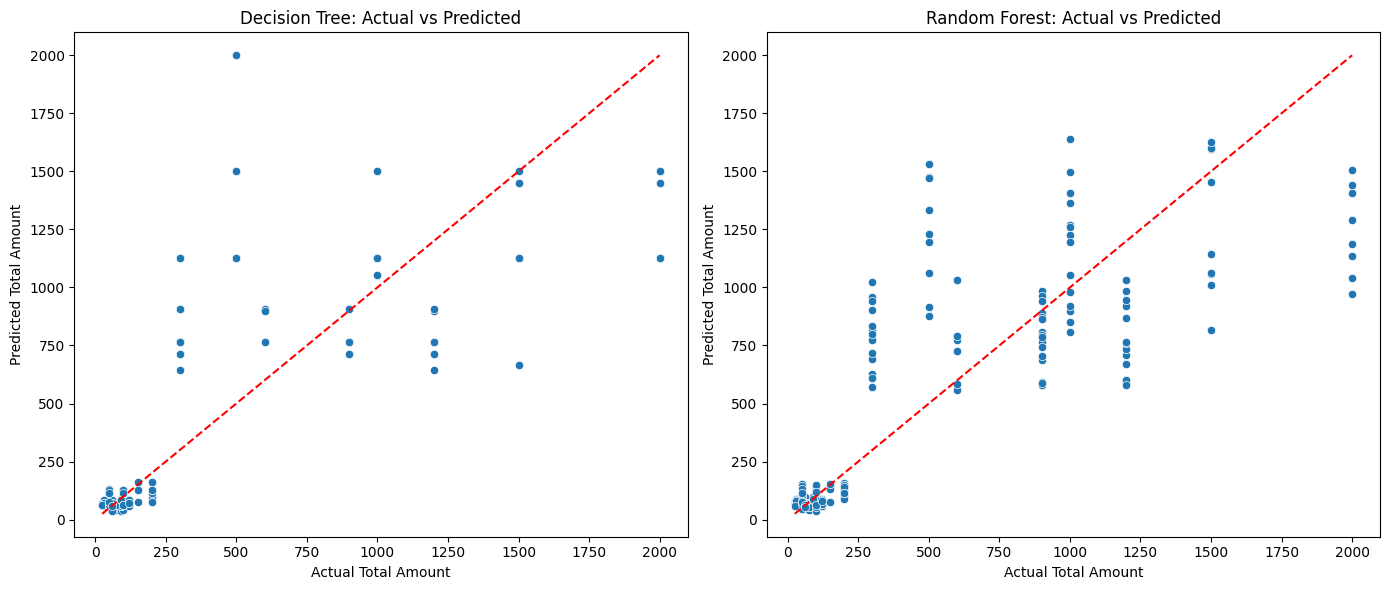

In [16]:

# Plot predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(x=y_test, y=dt_preds, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[0].set_title('Decision Tree: Actual vs Predicted')
axes[0].set_xlabel('Actual Total Amount')
axes[0].set_ylabel('Predicted Total Amount')

sns.scatterplot(x=y_test, y=rf_preds, ax=axes[1])
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
axes[1].set_title('Random Forest: Actual vs Predicted')
axes[1].set_xlabel('Actual Total Amount')
axes[1].set_ylabel('Predicted Total Amount')
plt.tight_layout()
plt.show()


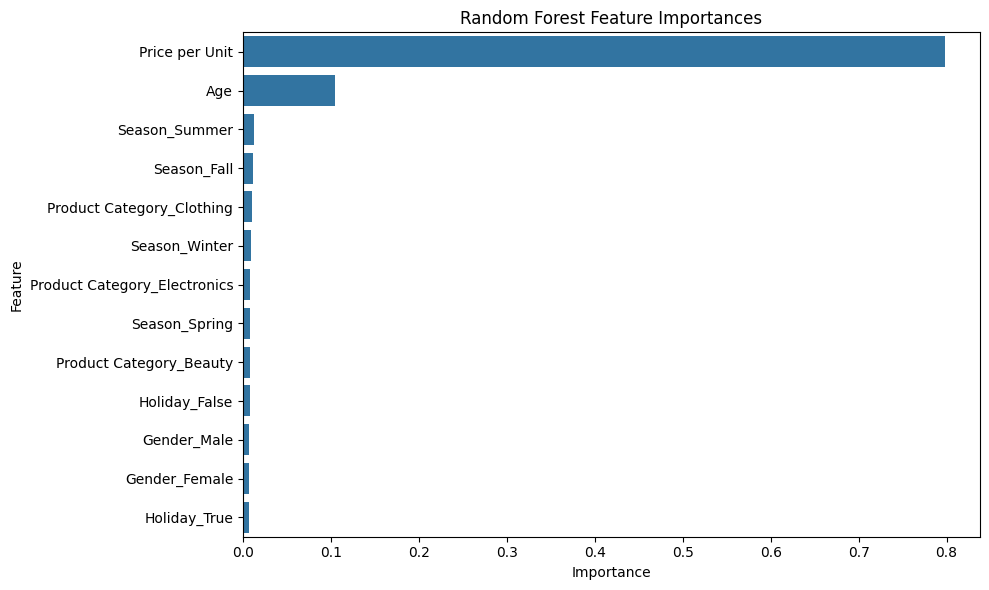

In [17]:

# Feature Importance for Random Forest
rf_model = rf_pipeline.named_steps['regressor']
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [18]:
# Hyperparameter Tuning for Model 1 : Decision Tree

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

dt_param_grid = {
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5, 10]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring='neg_root_mean_squared_error')
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Decision Tree CV RMSE:", -dt_grid.best_score_)

Best Decision Tree Parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 10}
Best Decision Tree CV RMSE: 319.4979489209554


In [19]:
#Hyperparameter Tuning for Model 2 : Random Forest

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest CV RMSE:", -rf_grid.best_score_)


Best Random Forest Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best Random Forest CV RMSE: 322.52615620134003


In [20]:
# Cross-validation on Decision Tree pipeline
dt_scores = cross_val_score(dt_pipeline, X_train, y_train,
                            cv=5, scoring='neg_root_mean_squared_error')
print("Decision Tree CV RMSE: %.2f ± %.2f" % (-dt_scores.mean(), dt_scores.std()))

# Cross-validation on Random Forest pipeline
rf_scores = cross_val_score(rf_pipeline, X_train, y_train,
                            cv=5, scoring='neg_root_mean_squared_error')
print("Random Forest CV RMSE: %.2f ± %.2f" % (-rf_scores.mean(), rf_scores.std()))

Decision Tree CV RMSE: 429.75 ± 17.15
Random Forest CV RMSE: 335.13 ± 29.50


In [21]:
r2_score(y_test, rf_preds)

0.6611830855448069